In [ ]:
!pip install --upgrade librosa


In [3]:
!sudo apt-get install portaudio19-dev
!pip install sounddevice
!apt install -y ffmpeg


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
portaudio19-dev is already the newest version (19.6.0-1.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


Escribe 'R' para grabar audio o 'C' para cargar un archivo de audio: c
Ingresa el nombre del archivo de audio: singing.mp3


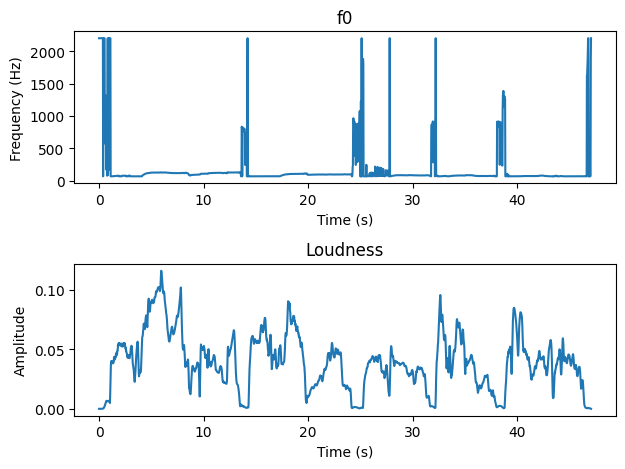

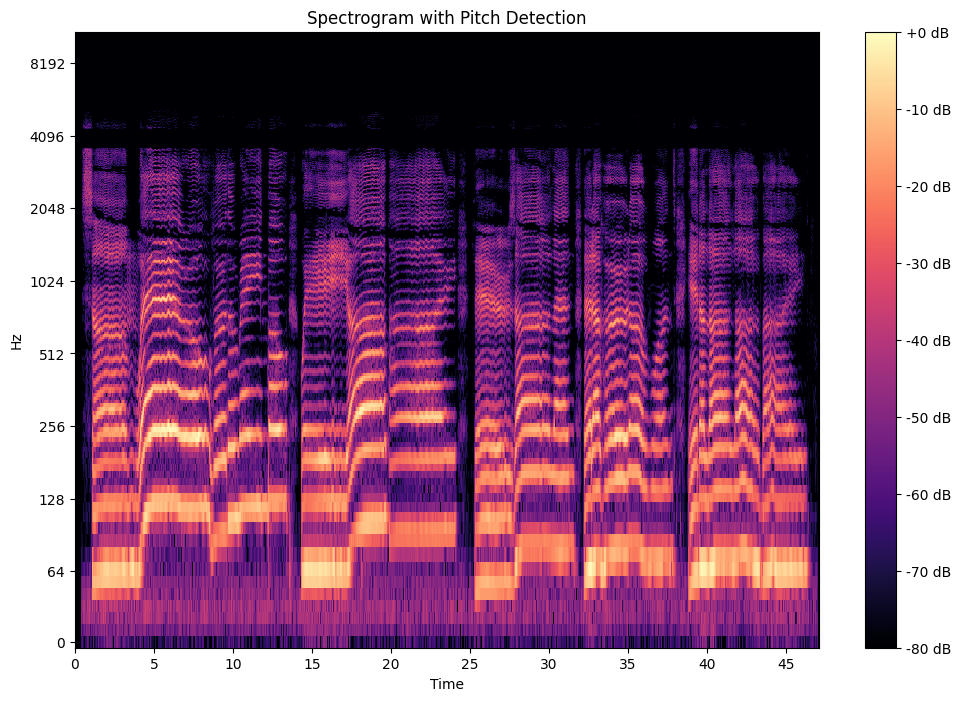

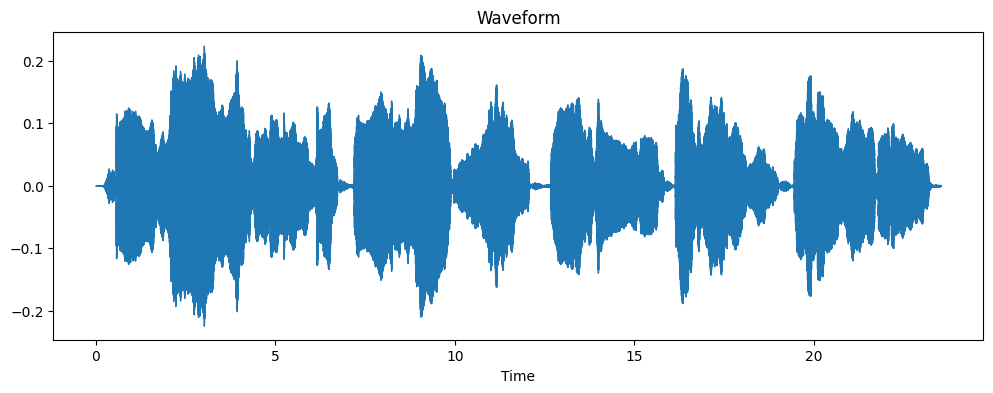

In [4]:
#@title Record or Upload Audio with Pitch Detection
#@markdown * Either record audio from microphone or upload audio from file (.mp3 or .wav)
#@markdown * Audio should be monophonic (single instrument / voice)
import sounddevice as sd
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display


def record_audio(duration, fs=44100):
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()
    return recording[:, 0]

def load_audio(filename):
    return librosa.load(filename, sr=None, mono=True)[0]

def extract_features(audio, sr):
    f0 = librosa.yin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    loudness = librosa.feature.rms(y=audio)
    return f0, loudness

def plot_features(f0, loudness):
    frames = range(len(f0))
    t = librosa.frames_to_time(frames)
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, f0, label='f0')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('f0')
    plt.subplot(2, 1, 2)
    plt.plot(t, loudness[0], label='loudness')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Loudness')
    plt.tight_layout()
    plt.show()

# Grabar o cargar audio
option = input("Escribe 'R' para grabar audio o 'C' para cargar un archivo de audio: ")
if option.upper() == 'R':
    duration = int(input("Ingresa la duración de la grabación en segundos: "))
    audio = record_audio(duration)
    sr = 44100
elif option.upper() == 'C':
    filename = input("Ingresa el nombre del archivo de audio: ")
    audio = load_audio(filename)
    sr = librosa.get_samplerate(filename)
else:
    print("Opción no válida.")


# Extraer y trazar características
if audio is not None:
    f0, loudness = extract_features(audio, sr)
    plot_features(f0, loudness)

# Calcula las magnitudes del espectrograma
D = np.abs(librosa.stft(audio))
magnitudes = librosa.amplitude_to_db(D, ref=np.max)

# Convierte el audio a una matriz de NumPy de tipo flotante
audio_np_float = np.array(audio, dtype=float)

# Grafica el espectrograma con detección de tono
plt.figure(figsize=(12, 8))
librosa.display.specshow(magnitudes, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram with Pitch Detection')
plt.show()

# Grafica la forma de onda del audio
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_np_float, sr=sr)
plt.title('Waveform')
plt.show()

from IPython.display import Audio
# Reproducir el audio
Audio(audio, rate=sr)

In [24]:
# Calcula la STFT del audio
D = librosa.stft(audio)

# Calcula la magnitud y la fase
magnitude, phase = librosa.magphase(D)

# Estima f0 utilizando el modelo CREPE
f0 = librosa.yin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

# Modifica la magnitud
bins_per_octave = 100  #@param {type:"number", min:1, max:100, step:1}
cqt = librosa.cqt(audio, sr=sr, bins_per_octave=bins_per_octave)
fmin = librosa.note_to_hz('C1')
bins = np.round(bins_per_octave * np.log2(f0 / fmin))
magnitude *= np.greater_equal.outer(bins, np.arange(magnitude.shape[0])).T

# Reconstruye la STFT
D_modified = magnitude * phase

# Realiza la inversa de la STFT para obtener el audio resintetizado
audio_resynthesized = librosa.istft(D_modified)

# Reproduce el audio
Audio(audio_resynthesized, rate=sr)